# Rainfall Prediction over Michigan Lake using CNN and RNN
-----------------------------
#### Teammates:
* Krishnakanth Naik Jarapala
* Uday Kiran Dasari

## Motivation: RNN using 8hr day session: Handling Class Imbalance

The motivation behind our analysis of five models using different strategies for handling class imbalance in time series data stems from the inherent limitations of traditional resampling techniques, which cannot be applied without disrupting temporal relationships.

Here are the 5 different strategies employed:
- No Bias
- Introducing Initial Bias
- Introducing Class weights
- Introducing both Bias and Class Weights
- Introducing Catergorical Focal Loss

### Necessary Imports

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import pandas as pd
import numpy as np
import pickle
import ast


# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline
import tempfile

import sklearn
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, ConvLSTM2D, Dropout, Flatten, RepeatVector, Reshape, TimeDistributed, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

2024-04-24 23:03:53.377548: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 23:03:56.388942: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Processing

In [2]:
df = pd.read_csv('./data/full_data_2014_2017_with_intensity.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df['year_month'] = df['datetime'].dt.strftime('%Y-%m')

# Set max_columns option to None to display all columns
pd.set_option('display.max_columns', None)

df = df.sort_values(['datetime']).reset_index(drop=True)
df.head()

,Date_UTC,Time_UTC,datetime,year_month,Temp_F,RH_pct,Wind_Spd_mph,Wind_Direction_deg,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,cloud_cover,Precip_in
0,2006-10-01,00:00,2006-10-01 00:00:00,2006-10,48.0,86.0,7,150,4100,10,984.0,0.0,0.00
1,2006-10-01,01:00,2006-10-01 01:00:00,2006-10,48.0,86.0,8,150,6000,10,983.7,0.0,0.00
2,2006-10-01,02:00,2006-10-01 02:00:00,2006-10,48.0,86.0,6,150,5500,10,982.7,0.0,0.00
3,2006-10-01,03:00,2006-10-01 03:00:00,2006-10,48.0,86.0,8,150,6000,10,982.0,0.0,0.00
4,2006-10-01,04:00,2006-10-01 04:00:00,2006-10,48.0,89.0,5,150,2200,8,982.0,0.0,0.02


**Taking Last 18months in the dataset**

In [3]:
recent_18month_records = df.year_month.unique().tolist()[-18:]

print(f"Selecting the data from this time period: {recent_18month_records}")
df = df[df.year_month.isin(recent_18month_records)].sort_values('datetime').reset_index(drop=True)
df.head()

Selecting the data from this time period: ['2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03']


,Date_UTC,Time_UTC,datetime,year_month,Temp_F,RH_pct,Wind_Spd_mph,Wind_Direction_deg,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,cloud_cover,Precip_in
0,2014-10-01,00:00,2014-10-01 00:00:00,2014-10,48.0,93.0,11,330,800,4,992.7,0.0,0.05
1,2014-10-01,01:00,2014-10-01 01:00:00,2014-10,48.0,93.0,9,340,800,4,993.3,0.0,0.05
2,2014-10-01,02:00,2014-10-01 02:00:00,2014-10,49.0,89.0,8,360,600,6,993.0,0.0,0.04
3,2014-10-01,03:00,2014-10-01 03:00:00,2014-10,48.0,87.0,10,30,1200,8,993.0,0.0,0.01
4,2014-10-01,04:00,2014-10-01 04:00:00,2014-10,48.0,86.0,8,50,1000,10,993.7,0.0,0.00


In [4]:
df.year_month.unique()

array(['2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03',
       '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03',
       '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03'],
      dtype=object)

In [5]:
df[df.Precip_in>0].Precip_in.describe()

count    1051.000000
mean        0.031465
std         0.038859
min         0.010000
25%         0.010000
50%         0.020000
75%         0.040000
max         0.450000
Name: Precip_in, dtype: float64

In [6]:
df.shape

(13128, 13)

### Feature Engineering - Timestamp and (wind_Speed + Wind_Direction)
* Timestamp makes no-sense - so lets convert that feature into a signal using sine and cos - create day & year of signals.
* If there is no-wind, then wind-direction doesn't matter - create a wind-vector (Wx, Wy) - which considers both direction and speed.

*Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly.*
* Direction shouldn't matter if the wind is not blowing.

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/h]')

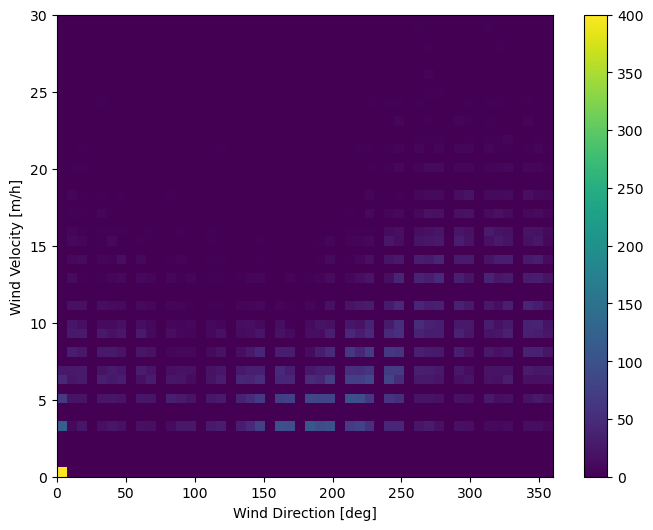

In [7]:
plt.hist2d(df['Wind_Direction_deg'], df['Wind_Spd_mph'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/h]')

*Create a Wind Vector (Wx, Wy) - using Wind-Direction + Wind-Speed - this will be easier for the model to interpret*

In [8]:
# Multiple wind_speed * Wind_Direction_in_rads along with cos & sine signals
df['Wind_x'] = (df['Wind_Spd_mph']) * np.cos(df['Wind_Direction_deg'] * np.pi / 180)
df['Wind_y'] = (df['Wind_Spd_mph']) * np.sin(df['Wind_Direction_deg'] * np.pi / 180)

df.head(2)

,Date_UTC,Time_UTC,datetime,year_month,Temp_F,RH_pct,Wind_Spd_mph,Wind_Direction_deg,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,cloud_cover,Precip_in,Wind_x,Wind_y
0,2014-10-01,00:00,2014-10-01 00:00:00,2014-10,48.0,93.0,11,330,800,4,992.7,0.0,0.05,9.526279,-5.500000
1,2014-10-01,01:00,2014-10-01 01:00:00,2014-10,48.0,93.0,9,340,800,4,993.3,0.0,0.05,8.457234,-3.078181


The distribution of wind vectors is much simpler for the model to correctly 


(-20.673237657289985, 25.0, -30.0, 18.79385241571817)

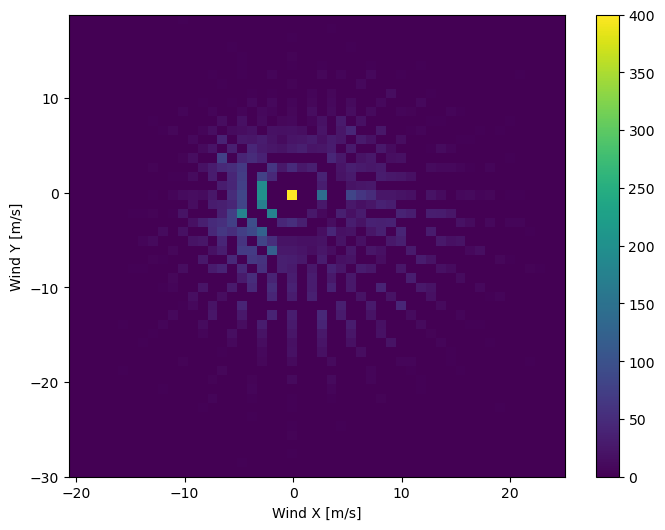

In [9]:
plt.hist2d(df['Wind_x'], df['Wind_y'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

Similarly, the `Date Time` column is very useful, but not in this string form. Start by converting it to frequency signals using Cos & Sine signals:

In [10]:
df['ts'] = df['datetime'].map(pd.Timestamp.timestamp)

# Convert the Timestamp into Cos-Sin signals - by Day & Year
day = 24*60*60
year = (365.2425)*day

df['day_sin'] = np.sin(df['ts'] * (2 * np.pi / day))
df['day_cos'] = np.cos(df['ts'] * (2 * np.pi / day))
df['year_sin'] = np.sin(df['ts'] * (2 * np.pi / year))
df['year_cos'] = np.cos(df['ts'] * (2 * np.pi / year))

In [11]:
df.head()

,Date_UTC,Time_UTC,datetime,year_month,Temp_F,RH_pct,Wind_Spd_mph,Wind_Direction_deg,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,cloud_cover,Precip_in,Wind_x,Wind_y,ts,day_sin,day_cos,year_sin,year_cos
0,2014-10-01,00:00,2014-10-01 00:00:00,2014-10,48.0,93.0,11,330,800,4,992.7,0.0,0.05,9.526279,-5.500000e+00,1.412122e+09,-1.331485e-12,1.000000,-0.999946,-0.010354
1,2014-10-01,01:00,2014-10-01 01:00:00,2014-10,48.0,93.0,9,340,800,4,993.3,0.0,0.05,8.457234,-3.078181e+00,1.412125e+09,2.588190e-01,0.965926,-0.999954,-0.009637
2,2014-10-01,02:00,2014-10-01 02:00:00,2014-10,49.0,89.0,8,360,600,6,993.0,0.0,0.04,8.000000,-1.959435e-15,1.412129e+09,5.000000e-01,0.866025,-0.999960,-0.008920
3,2014-10-01,03:00,2014-10-01 03:00:00,2014-10,48.0,87.0,10,30,1200,8,993.0,0.0,0.01,8.660254,5.000000e+00,1.412132e+09,7.071068e-01,0.707107,-0.999966,-0.008203
4,2014-10-01,04:00,2014-10-01 04:00:00,2014-10,48.0,86.0,8,50,1000,10,993.7,0.0,0.00,5.142301,6.128356e+00,1.412136e+09,8.660254e-01,0.500000,-0.999972,-0.007487


Text(0.5, 1.0, 'Time of day signal')

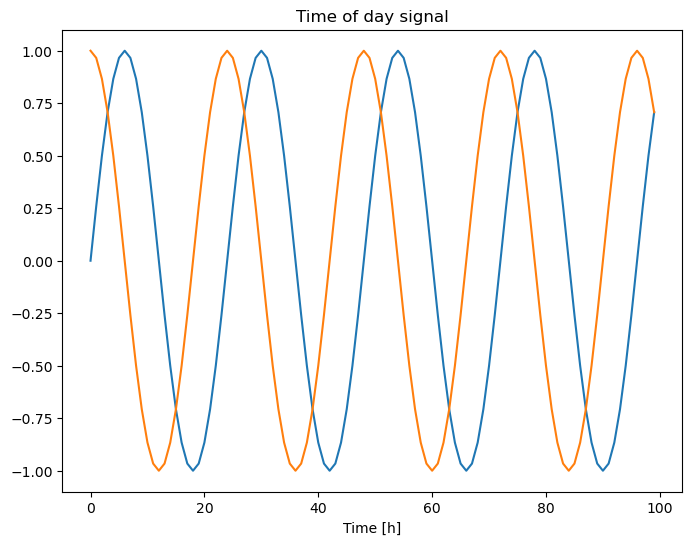

In [12]:
plt.plot(np.array(df['day_sin'])[:100])
plt.plot(np.array(df['day_cos'])[:100])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Time of day signal')

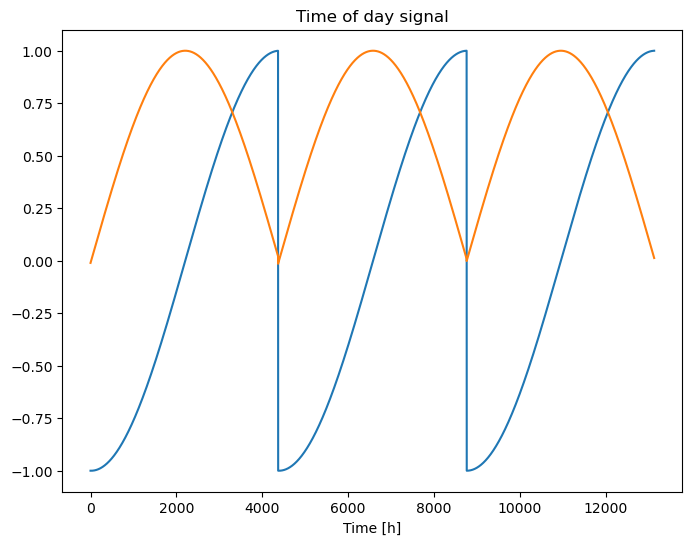

In [13]:
plt.plot(np.array(df['year_sin']))
plt.plot(np.array(df['year_cos']))
plt.xlabel('Time [h]')
plt.title('Time of day signal')

**Drop unnecessary features and prepare the new set of data**

In [14]:
features_to_consider =  ['datetime', 'year_month', 'Time_UTC', 'year_sin', 'year_cos', 'day_sin', 'day_cos', 'Temp_F', 
    'RH_pct', 'Low_Cloud_Ht_ft', 'Visibility_mi', 'Atm_Press_hPa', 'cloud_cover', 
    'Wind_x', 'Wind_y',  'Precip_in']

df_raw = df.copy()

df = df[features_to_consider]
df.head()

,datetime,year_month,Time_UTC,year_sin,year_cos,day_sin,day_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,cloud_cover,Wind_x,Wind_y,Precip_in
0,2014-10-01 00:00:00,2014-10,00:00,-0.999946,-0.010354,-1.331485e-12,1.000000,48.0,93.0,800,4,992.7,0.0,9.526279,-5.500000e+00,0.05
1,2014-10-01 01:00:00,2014-10,01:00,-0.999954,-0.009637,2.588190e-01,0.965926,48.0,93.0,800,4,993.3,0.0,8.457234,-3.078181e+00,0.05
2,2014-10-01 02:00:00,2014-10,02:00,-0.999960,-0.008920,5.000000e-01,0.866025,49.0,89.0,600,6,993.0,0.0,8.000000,-1.959435e-15,0.04
3,2014-10-01 03:00:00,2014-10,03:00,-0.999966,-0.008203,7.071068e-01,0.707107,48.0,87.0,1200,8,993.0,0.0,8.660254,5.000000e+00,0.01
4,2014-10-01 04:00:00,2014-10,04:00,-0.999972,-0.007487,8.660254e-01,0.500000,48.0,86.0,1000,10,993.7,0.0,5.142301,6.128356e+00,0.00


**Above dataset is the cleaned, processed along with cloud-cover (pixel-intensity of clouds) information**

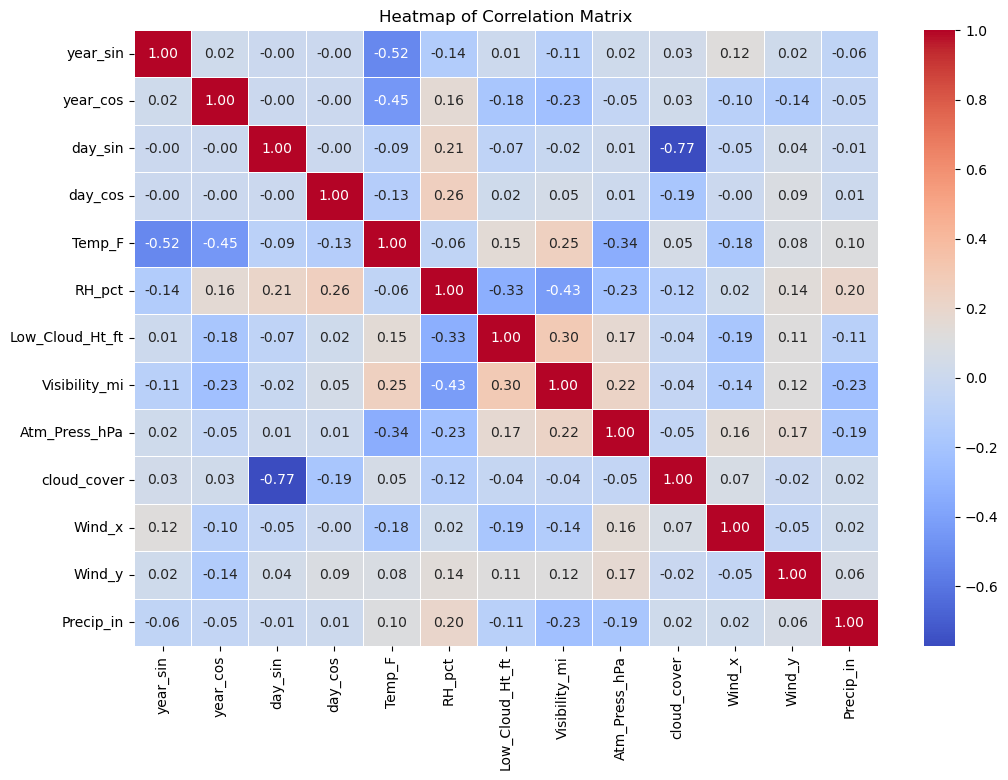

In [15]:
correlation_matrix = df.iloc[:, 3:].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()

### Objective - Further processing to be done like sequence creation
* RNN / LSTM - To predict the precip
* Considering last n_time_sequence --> n = 1, 2, 3 days --> to predict next y days --> y = 1, 2, 3 (Compute the accuracies)

In [16]:
df[df.Precip_in > 0].Precip_in.describe()

count    1051.000000
mean        0.031465
std         0.038859
min         0.010000
25%         0.010000
50%         0.020000
75%         0.040000
max         0.450000
Name: Precip_in, dtype: float64

#### Window Creation
**Since the Data is not continuous over the years, so lets create the sequence dataset by each window: [2014-10 - 2015-03] + [2015-10 - 2016-03] + [2016-10 - 2017-03]**

In [17]:
mnts= df.year_month.unique().tolist()
yr_mnt_lst = []
for i in range(0, len(mnts), 6):
    # print(mnts[i: i+6])
    yr_mnt_lst.append(mnts[i: i+6])

yr_mnt_lst

[['2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03'],
 ['2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03'],
 ['2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03']]

In [18]:
df['day_session'] = df['Time_UTC'].apply(lambda x: (int(x[:2])//8))
df['date'] = df['datetime'].dt.strftime('%Y-%m-%d')


#### Limiting the records per day
We divide the total hours to 3 sessions(8Hours Duration) and we select the row with max precip in a session as the record for that whole session.
In this way we'll have 3 records per day
* 0-8 ==> day-session- 1
* 8-16 ==> day-session- 2
* 16-24 ==> day-session- 3

In [19]:
df['RN'] = df.sort_values(['date','day_session', 'Precip_in'], ascending=[True,True, False]).groupby(['date','day_session']).cumcount()+1

filtered_data = df[df.RN == 1].sort_values('datetime').reset_index(drop=True)
filtered_data.head()

,datetime,year_month,Time_UTC,year_sin,year_cos,day_sin,day_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,cloud_cover,Wind_x,Wind_y,Precip_in,day_session,date,RN
0,2014-10-01 00:00:00,2014-10,00:00,-0.999946,-0.010354,-1.331485e-12,1.000000,48.0,93.0,800,4,992.7,0.000000,9.526279,-5.500000e+00,0.05,0,2014-10-01,1
1,2014-10-01 08:00:00,2014-10,08:00,-0.999989,-0.004620,8.660254e-01,-0.500000,54.0,81.0,1000,10,995.0,0.000000,0.000000,0.000000e+00,0.00,1,2014-10-01,1
2,2014-10-01 16:00:00,2014-10,16:00,-0.999999,0.001115,-8.660254e-01,-0.500000,64.0,64.0,3300,10,991.3,52.587691,-6.000000,7.347881e-16,0.00,2,2014-10-01,1
3,2014-10-02 07:00:00,2014-10,07:00,-0.999930,0.011866,9.659258e-01,-0.258819,57.0,86.0,3900,4,990.7,0.000000,-2.500000,4.330127e+00,0.11,0,2014-10-02,1
4,2014-10-02 10:00:00,2014-10,10:00,-0.999902,0.014016,5.000000e-01,-0.866025,57.0,93.0,1800,2,989.7,0.000000,-2.298133,1.928363e+00,0.28,1,2014-10-02,1


In [20]:
filtered_data.shape

(1641, 19)

#### Defining the windows

In [21]:
# Creating the windows where the data is continuous
window1 = ['2014-10', '2014-11', '2014-12', '2015-01','2015-02', '2015-03']
window2 = ['2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03']
window3 = ['2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03']


tdf = filtered_data.copy()
tdf['time_seq_window'] = -1 #imputting the window values with -1

tdf.loc[tdf.year_month.isin(window1), 'time_seq_window'] = 1
tdf.loc[tdf.year_month.isin(window2), 'time_seq_window'] = 2
tdf.loc[tdf.year_month.isin(window3), 'time_seq_window'] = 3

tdf.head()

,datetime,year_month,Time_UTC,year_sin,year_cos,day_sin,day_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,cloud_cover,Wind_x,Wind_y,Precip_in,day_session,date,RN,time_seq_window
0,2014-10-01 00:00:00,2014-10,00:00,-0.999946,-0.010354,-1.331485e-12,1.000000,48.0,93.0,800,4,992.7,0.000000,9.526279,-5.500000e+00,0.05,0,2014-10-01,1,1
1,2014-10-01 08:00:00,2014-10,08:00,-0.999989,-0.004620,8.660254e-01,-0.500000,54.0,81.0,1000,10,995.0,0.000000,0.000000,0.000000e+00,0.00,1,2014-10-01,1,1
2,2014-10-01 16:00:00,2014-10,16:00,-0.999999,0.001115,-8.660254e-01,-0.500000,64.0,64.0,3300,10,991.3,52.587691,-6.000000,7.347881e-16,0.00,2,2014-10-01,1,1
3,2014-10-02 07:00:00,2014-10,07:00,-0.999930,0.011866,9.659258e-01,-0.258819,57.0,86.0,3900,4,990.7,0.000000,-2.500000,4.330127e+00,0.11,0,2014-10-02,1,1
4,2014-10-02 10:00:00,2014-10,10:00,-0.999902,0.014016,5.000000e-01,-0.866025,57.0,93.0,1800,2,989.7,0.000000,-2.298133,1.928363e+00,0.28,1,2014-10-02,1,1


In [22]:
tdf.groupby(['year_month', 'time_seq_window'])['datetime'].count()

year_month  time_seq_window
2014-10     1                  93
2014-11     1                  90
2014-12     1                  93
2015-01     1                  93
2015-02     1                  84
2015-03     1                  93
2015-10     2                  93
2015-11     2                  90
2015-12     2                  93
2016-01     2                  93
2016-02     2                  87
2016-03     2                  93
2016-10     3                  93
2016-11     3                  90
2016-12     3                  93
2017-01     3                  93
2017-02     3                  84
2017-03     3                  93
Name: datetime, dtype: int64

In [23]:
tdf.Precip_in.describe()

count    1641.000000
mean        0.008952
std         0.028463
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.450000
Name: Precip_in, dtype: float64

In [24]:
tdf[tdf.Precip_in > 0].Precip_in.describe()

count    377.000000
mean       0.038966
std        0.048589
min        0.010000
25%        0.010000
50%        0.020000
75%        0.050000
max        0.450000
Name: Precip_in, dtype: float64

### Precip Class Creation
        * 0 - No Rain
        * (0 - 0.019) - Med Rain
        * anything above 0.019 - High Rain

In [25]:
def classify_precip(val):
    high_rain_lower_limit = 0.020
    if val == 0:
        return "No_Rain"
    elif (val > 0) & (val <= high_rain_lower_limit):
        return "Medium_Rain"
    elif (val > high_rain_lower_limit):
        return "High_Rain"

In [26]:
tdf['Precip_in_class'] = tdf['Precip_in'].apply(lambda x: classify_precip(x))
100*tdf.Precip_in_class.value_counts(normalize=True)

Precip_in_class
No_Rain        77.026204
Medium_Rain    12.675198
High_Rain      10.298598
Name: proportion, dtype: float64

### OneHot Encoding

In [27]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

# Assuming your class variable is named 'classes' and it is a list or array
classes = tdf['Precip_in_class'].tolist()  # Your class variable

# Convert class variable to one-hot encoding
label_binarizer = LabelBinarizer()
one_hot_encoded = label_binarizer.fit_transform(classes)

# Convert the one-hot encoded array to a DataFrame
one_hot_df = pd.DataFrame(one_hot_encoded, columns=label_binarizer.classes_)

# Concatenate the one-hot encoded DataFrame with the original DataFrame 'tdf'
tdf_with_one_hot = pd.concat([tdf, one_hot_df], axis=1)


# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(classes), y=classes)

print("One-hot encoded:")
print(one_hot_encoded)
print("Class weights:")
print(class_weights)


One-hot encoded:
[[1 0 0]
 [0 0 1]
 [0 0 1]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]
Class weights:
[3.23668639 2.62980769 0.43275316]


In [28]:
tdf.shape,tdf.Precip_in_class.value_counts()

((1641, 21),
 Precip_in_class
 No_Rain        1264
 Medium_Rain     208
 High_Rain       169
 Name: count, dtype: int64)

In [29]:
len(tdf.columns)

21

In [30]:
tdf_with_one_hot.head()

,datetime,year_month,Time_UTC,year_sin,year_cos,day_sin,day_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,cloud_cover,Wind_x,Wind_y,Precip_in,day_session,date,RN,time_seq_window,Precip_in_class,High_Rain,Medium_Rain,No_Rain
0,2014-10-01 00:00:00,2014-10,00:00,-0.999946,-0.010354,-1.331485e-12,1.000000,48.0,93.0,800,4,992.7,0.000000,9.526279,-5.500000e+00,0.05,0,2014-10-01,1,1,High_Rain,1,0,0
1,2014-10-01 08:00:00,2014-10,08:00,-0.999989,-0.004620,8.660254e-01,-0.500000,54.0,81.0,1000,10,995.0,0.000000,0.000000,0.000000e+00,0.00,1,2014-10-01,1,1,No_Rain,0,0,1
2,2014-10-01 16:00:00,2014-10,16:00,-0.999999,0.001115,-8.660254e-01,-0.500000,64.0,64.0,3300,10,991.3,52.587691,-6.000000,7.347881e-16,0.00,2,2014-10-01,1,1,No_Rain,0,0,1
3,2014-10-02 07:00:00,2014-10,07:00,-0.999930,0.011866,9.659258e-01,-0.258819,57.0,86.0,3900,4,990.7,0.000000,-2.500000,4.330127e+00,0.11,0,2014-10-02,1,1,High_Rain,1,0,0
4,2014-10-02 10:00:00,2014-10,10:00,-0.999902,0.014016,5.000000e-01,-0.866025,57.0,93.0,1800,2,989.7,0.000000,-2.298133,1.928363e+00,0.28,1,2014-10-02,1,1,High_Rain,1,0,0


In [31]:
cols_to_use = ['datetime', 'year_month', 'time_seq_window', 'year_sin', 'year_cos', 'day_sin', 'day_cos', 'Temp_F', 'RH_pct', 
        'Low_Cloud_Ht_ft', 'Visibility_mi', 'Wind_x', 'Wind_y', 'Atm_Press_hPa', 'cloud_cover',
        'High_Rain', 'Medium_Rain', 'No_Rain']

final_df = tdf_with_one_hot[cols_to_use].copy()
final_df = final_df.sort_values('datetime').reset_index(drop=True)
final_df.head()

,datetime,year_month,time_seq_window,year_sin,year_cos,day_sin,day_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,Wind_x,Wind_y,Atm_Press_hPa,cloud_cover,High_Rain,Medium_Rain,No_Rain
0,2014-10-01 00:00:00,2014-10,1,-0.999946,-0.010354,-1.331485e-12,1.000000,48.0,93.0,800,4,9.526279,-5.500000e+00,992.7,0.000000,1,0,0
1,2014-10-01 08:00:00,2014-10,1,-0.999989,-0.004620,8.660254e-01,-0.500000,54.0,81.0,1000,10,0.000000,0.000000e+00,995.0,0.000000,0,0,1
2,2014-10-01 16:00:00,2014-10,1,-0.999999,0.001115,-8.660254e-01,-0.500000,64.0,64.0,3300,10,-6.000000,7.347881e-16,991.3,52.587691,0,0,1
3,2014-10-02 07:00:00,2014-10,1,-0.999930,0.011866,9.659258e-01,-0.258819,57.0,86.0,3900,4,-2.500000,4.330127e+00,990.7,0.000000,1,0,0
4,2014-10-02 10:00:00,2014-10,1,-0.999902,0.014016,5.000000e-01,-0.866025,57.0,93.0,1800,2,-2.298133,1.928363e+00,989.7,0.000000,1,0,0


In [32]:
final_df.shape

(1641, 18)

### Standardizing the features
**['Temp_F', 'RH_pct', 'Wind_Spd_mph', 'Wind_Direction_deg', 'Low_Cloud_Ht_ft', 'Visibility_mi','Atm_Press_hPa', 'cloud_cover']**

In [33]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Windows - to select the dataset
train_data_windows = [1,2,3]

#cols to standardize
cols_to_standardize = ['year_sin', 'year_cos', 'day_sin', 'day_cos', 'Temp_F', 'RH_pct', 'Low_Cloud_Ht_ft',
    'Visibility_mi', 'Wind_x', 'Wind_y', 'Atm_Press_hPa', 'cloud_cover']

TEST_Records = 200 # Number of Test data

# Train and Test datasets
train_df = final_df.iloc[:-TEST_Records, :].reset_index(drop=True)
test_df = final_df.iloc[-TEST_Records:, :].reset_index(drop=True)

print(f"Train Dataset shape: {train_df.shape}, Test Dataset Shape: {test_df.shape}")

# Fit and transform the scaler on the Full data
train_df_scaled = train_df.copy()
train_df_scaled[cols_to_standardize] = scaler.fit_transform(train_df[cols_to_standardize])

# Transform the test data using the same scaler
test_df_scaled = test_df.copy()
test_df_scaled[cols_to_standardize] = scaler.transform(test_df[cols_to_standardize])
print(f"Train scaled Dataset shape: {train_df_scaled.shape}, Test scaled Dataset Shape: {test_df_scaled.shape}")


Train Dataset shape: (1441, 18), Test Dataset Shape: (200, 18)
Train scaled Dataset shape: (1441, 18), Test scaled Dataset Shape: (200, 18)


In [34]:
test_df_scaled.head()

,datetime,year_month,time_seq_window,year_sin,year_cos,day_sin,day_cos,Temp_F,RH_pct,Low_Cloud_Ht_ft,Visibility_mi,Wind_x,Wind_y,Atm_Press_hPa,cloud_cover,High_Rain,Medium_Rain,No_Rain
0,2017-01-24 08:00:00,2017-01,3,0.762815,0.851802,1.196587,-0.703829,0.088088,1.668641,-0.772669,-1.260669,0.299181,-0.575661,-0.755074,-0.660445,0,0,1
1,2017-01-24 16:00:00,2017-01,3,0.770524,0.844324,-1.232541,-0.703829,0.154860,1.371274,-0.736217,-1.582195,0.734327,-0.528030,-0.755074,1.612341,0,0,1
2,2017-01-25 00:00:00,2017-01,3,0.778212,0.836748,-0.017977,1.436029,0.154860,1.594299,-0.772669,-0.617616,-0.065687,-0.120118,-0.892824,-0.660445,0,0,1
3,2017-01-25 14:00:00,2017-01,3,0.791620,0.823258,-0.719206,-1.225991,0.021315,1.371274,-0.772669,-1.582195,0.858190,0.915931,-1.814686,1.009375,0,1,0
4,2017-01-25 17:00:00,2017-01,3,0.794485,0.820329,-1.372648,-0.359767,-0.045457,1.668641,-0.772669,-2.225247,-0.065687,0.397906,-1.846474,1.312817,1,0,0


### Sequence Creation

In [35]:
# preparing independent and dependent features
def prepare_data(df, window_type, cols_to_use,  n_time_steps, future_steps):
    
    data = df[df.time_seq_window == window_type][cols_to_use].values

    # print(data[0])

    X, y =[],[]
    for i in range(len(data)):
        end_ix = i + n_time_steps #selectingg the end_idx based on the timestep

        # check if we are beyond the sequence
        if end_ix  + future_steps > len(data):
            break

        # gather input and output parts of the pattern
        seq_x = data[i:end_ix, :-3] #selecting ith to end-idx and removing label
        seq_y = data[end_ix: end_ix  + future_steps, -3:] #end-idx - last column is the label (precip_in)
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def create_sequences(data,  feature_columns, label_columns, past_time_steps=72, future_time_steps=24):
    X, y = [], []
    
    # feature_columns = features_to_consider[:-3]  # exclude target lables, last 3 columns are the one-hot encoded labels
    # label_columns = features_to_consider[-3:]    # One-hot encoded labels
    
    for i in range(len(data) - past_time_steps - future_time_steps + 1):
        X.append(data.iloc[i : (i + past_time_steps)][feature_columns].values)
        y.append(data.iloc[i + past_time_steps : i + past_time_steps + future_time_steps][label_columns].values)
    
    return np.array(X), np.array(y)

### Training Dataset 
* Historical n time steps - 9 ==> (3 days * 3 Records)
* Futures Steps - 3 ==> (1 days * 3 Records) 1 day in future

In [36]:
# selecting the most important features
cols_to_use = ['year_sin', 'year_cos', 'day_sin', 'day_cos', 'Temp_F', 'RH_pct', 'Low_Cloud_Ht_ft',
    'Visibility_mi', 'Wind_x', 'Wind_y', 'Atm_Press_hPa', 'cloud_cover',
    'High_Rain', 'Medium_Rain', 'No_Rain']

    
n_time_steps = 9 # considering 3 days of historical data for now
future_steps = 3 # considering 1 day to predict in future

time_windows = [1, 2, 3] # 1, 2, 3 - time window data

# Select the features and labels
feature_columns = cols_to_use[:-3]
label_columns = cols_to_use[-3:]

### Training Data
data_x, data_y = [], []

for i in time_windows:
    # x, y = prepare_data(train_df_scaled, i, cols_to_use, n_time_steps, future_steps)
    x, y = create_sequences(train_df_scaled[train_df_scaled.time_seq_window == i], feature_columns, label_columns, n_time_steps, future_steps)

    data_x.append(x)
    data_y.append(y)

# Concatenate the arrays along the first axis after the loop
train_x = np.concatenate(data_x, axis=0)
train_y = np.concatenate(data_y, axis=0)


# data_x.shape, data_y.shape
train_x.shape, train_y.shape

((1408, 9, 12), (1408, 3, 3))

In [37]:
### Test Data
test_x, test_y = create_sequences(test_df_scaled, feature_columns, label_columns, n_time_steps, future_steps)
test_x.shape, test_y.shape

((189, 9, 12), (189, 3, 3))

## Model Evaluation

### Metrics and Model Definition

In [38]:
METRICS = [
      tf.keras.metrics.CategoricalCrossentropy(name='categorical cross entropy'),  # same as model's loss
      tf.keras.metrics.MeanSquaredError(name='Brier score'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
    # Initialize output_bias if provided
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        # Define the LSTM model with TimeDistributed Dense layer
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        Reshape((train_y.shape[1], -1)),
        TimeDistributed(Dense(train_y.shape[2],activation = 'softmax',bias_initializer=output_bias))
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=metrics)
    return model

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',verbose=1,patience=10, mode='max',restore_best_weights=True)

2024-04-24 23:04:06.041542: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11437 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:04:00.0, compute capability: 6.0


In [39]:
EPOCHS = 100
BATCH_SIZE = 64
BUFFER_SIZE = 1000

### Computing Bias and Class Weights

**The probabilities are defined as:**
$$ p(\text{NR}) = \frac{\text{NR}}{\text{Total}} $$
$$ p(\text{MR}) = \frac{\text{MR}}{\text{Total}} $$
$$ p(\text{HR}) = \frac{\text{HR}}{\text{Total}} $$

**The bias calculations are:**
$$ \text{Bias} = \left( \log\left(\frac{p(\text{NR})}{p(\text{NR})}\right), \log\left(\frac{p(\text{MR})}{p(\text{NR})}\right), \log\left(\frac{p(\text{HR})}{p(\text{NR})}\right) \right) $$


In [40]:
# Calculate the counts for each class
counts = {
    'no_rain': train_df['No_Rain'].sum(),
    'medium_rain': train_df['Medium_Rain'].sum(),
    'high_rain': train_df['High_Rain'].sum()
}

# Calculate the probabilities for each class
total_counts = sum(counts.values())
probabilities = {k: v / total_counts for k, v in counts.items()}

# Calculate the initial bias for each class
# In this case, we use 'no_rain' as the reference class probability
reference_probability = probabilities['no_rain']
initial_biases = np.log([
    probabilities['high_rain'] / reference_probability,
    probabilities['medium_rain'] / reference_probability,
    probabilities['no_rain'] / probabilities['no_rain']]
    )

print("Initial Biases:", initial_biases)

Initial Biases: [-2.0225832  -1.80352964  0.        ]


In [41]:
class_weights = {
    0: (1 / counts['high_rain']) * (total_counts / 3),
    1: (1 / counts['medium_rain']) * (total_counts / 3),
    2: (1 / counts['no_rain']) * (total_counts / 3)
}

print("Class Weights:", class_weights)

Class Weights: {0: 3.2675736961451243, 1: 2.624772313296903, 2: 0.4323432343234323}


## Helper functions

In [42]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()
# def eval(test_x,test_y,model):
#     # test_x_rescaled= np.array(test_x)[:,:,:,np.newaxis,np.newaxis]
#     # Assuming `model.predict(test_x)` returns a shape of (2405, 24, 3)
#     predictions = model.predict(test_x)
#     pred_indices = np.argmax(predictions, axis=2)  # Convert probabilities to class indices per timestep

#     test_y_indices = np.argmax(test_y, axis=2)  # Same for test_y
#     # Check shapes and types if necessary:
#     print("Shape of pred:", pred_indices.shape)
#     print("Shape of test_y:", test_y_indices.shape)

#     # Flatten the arrays to treat each timestep as an independent sample
#     pred_flat = pred_indices.flatten()
#     test_y_flat = test_y_indices.flatten()

#     # Calculate accuracy
#     accuracy = accuracy_score(test_y_flat, pred_flat)
#     print("Accuracy:", accuracy)

#     # Generate classification report
#     report = classification_report(test_y_flat, pred_flat,zero_division=0)
#     print(report)



from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def eval(test_x, test_y, model):
    # Assuming `model.predict(test_x)` returns a shape of (2405, 24, 3)
    predictions = model.predict(test_x)
    pred_indices = np.argmax(predictions, axis=2)  # Convert probabilities to class indices per timestep

    test_y_indices = np.argmax(test_y, axis=2)  # Same for test_y
    # Check shapes and types if necessary:
    print("Shape of pred:", pred_indices.shape)
    print("Shape of test_y:", test_y_indices.shape)

    # Flatten the arrays to treat each timestep as an independent sample
    pred_flat = pred_indices.flatten()
    test_y_flat = test_y_indices.flatten()

    # Calculate accuracy
    accuracy = accuracy_score(test_y_flat, pred_flat)
    print("Accuracy:", accuracy)

    # Generate classification report
    report = classification_report(test_y_flat, pred_flat, zero_division=0)
    print(report)

    # Generate confusion matrix
    matrix = confusion_matrix(test_y_flat, pred_flat)
    print("Confusion Matrix:\n", matrix)
    # Plot the confusion matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_y_flat), yticklabels=np.unique(test_y_flat))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


# Note: Make sure to pass actual model and data when calling the eval function.


### A simple RNN model without bias, class weights

In [43]:
rnnmodel = make_model()
rnnmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 9, 50)             12600     
                                                                 
 dropout (Dropout)           (None, 9, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 9, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 9, 50)             0         
                                                                 
 reshape (Reshape)           (None, 3, 150)            0         
                                                                 
 time_distributed (TimeDist  (None, 3, 3)              453       
 ributed)                                                        
                                                        

In [44]:
results = rnnmodel.evaluate(train_x, train_y, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

2024-04-24 23:04:08.231180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903


Loss: 0.9097


### A simple RNN model with bias

In [45]:
rnnmodel1 = make_model(output_bias=initial_biases)

In [46]:
results = rnnmodel1.evaluate(train_x, train_y, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6901


**`Analysis:`**
- Loss Before: 1.2738
- Loss after introducing bias: 0.6860

### Saving the weights with initial weights for bias

In [47]:
# Define the file path for the initial weights
# This will create a file named 'initial_weights.h5' in the current directory
initial_weights_path = './data/initial_weights.h5'

# Save the initial weights
rnnmodel1.save_weights(initial_weights_path)

print(f"Initial weights are saved to {initial_weights_path}")

Initial weights are saved to ./data/initial_weights.h5


### 1. Model with Zero bias and Fitting to the data - ZBModel

In [48]:
zbmodel = make_model()
zbmodel.load_weights(initial_weights_path)
# Reset the biases of the last layer to zero
dense_layer = zbmodel.layers[-1].layer  # Access the Dense layer wrapped by TimeDistributed
zero_bias = np.zeros(dense_layer.units)  # Create a zero array with the same length as the number of units in the Dense layer
dense_layer.bias.assign(zero_bias)       # Assign the zero array to the bias of the Dense layer

zero_bias_history = zbmodel.fit(
    train_x,
    train_y,
    batch_size=BATCH_SIZE,
    validation_split=0.15,
    epochs=EPOCHS, 
    verbose=1)

Epoch 1/100


2024-04-24 23:04:14.203219: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2ace7cde2680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 23:04:14.203286: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla P100-PCIE-12GB, Compute Capability 6.0
2024-04-24 23:04:14.216216: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-24 23:04:14.561405: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 [==============================] - 6s 70ms/step - loss: 1.0180 - categorical cross entropy: 0.8649 - Brier score: 0.1670 - tp: 3424.0000 - fp: 990.0000 - tn: 23082.0000 - fn: 8612.0000 - categorical_accuracy: 0.7277 - precision: 0.7757 - recall: 0.2845 - auc: 0.8270 - prc: 0.6925 - val_loss: 0.9418 - val_categorical cross entropy: 0.9418 - val_Brier score: 0.1851 - val_tp: 99.0000 - val_fp: 32.0000 - val_tn: 1240.0000 - val_fn: 537.0000 - val_categorical_accuracy: 0.7531 - val_precision: 0.7557 - val_recall: 0.1557 - val_auc: 0.8143 - val_prc: 0.6928
Epoch 2/100
19/19 [==============================] - 0s 11ms/step - loss: 0.8009 - categorical cross entropy: 0.8009 - Brier score: 0.1491 - tp: 1862.0000 - fp: 500.0000 - tn: 6676.0000 - fn: 1726.0000 - categorical_accuracy: 0.7776 - precision: 0.7883 - recall: 0.5190 - auc: 0.8404 - prc: 0.7264 - val_loss: 0.8148 - val_categorical cross entropy: 0.8148 - val_Brier score: 0.1488 - val_tp: 380.0000 - val_fp: 117.0000 - val_tn: 1155.0

6/6 [==============================] - 1s 4ms/step
Shape of pred: (189, 3)
Shape of test_y: (189, 3)
Accuracy: 0.6419753086419753
              precision    recall  f1-score   support

           0       0.05      0.05      0.05        60
           1       0.18      0.09      0.12        69
           2       0.76      0.81      0.78       438

    accuracy                           0.64       567
   macro avg       0.33      0.32      0.32       567
weighted avg       0.61      0.64      0.62       567

Confusion Matrix:
 [[  3   2  55]
 [  3   6  60]
 [ 58  25 355]]


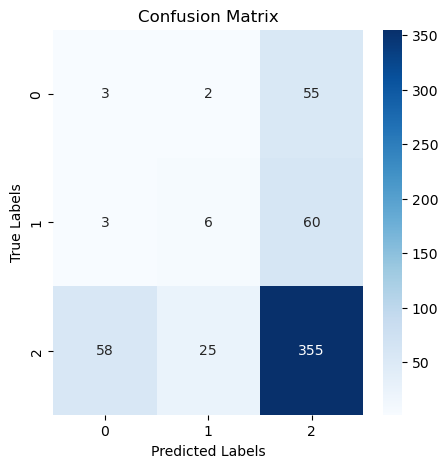

In [49]:
eval(test_x,test_y,zbmodel)

**Observation:**

Model 1 with Zero bias demonstrates effective prediction capabilities primarily for the predominant Class 2 but performs poorly on the minority classes (Class 0 and Class 1). This uneven performance indicates a potential bias towards the majority class.

### 2. Model with Bias and fitting to the data -BModel

In [50]:
bmodel = make_model()
bmodel.load_weights(initial_weights_path)
careful_bias_history = bmodel.fit(
    train_x,
    train_y,
    validation_split=0.15,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1)

Epoch 1/100
19/19 [==============================] - 5s 68ms/step - loss: 0.6799 - categorical cross entropy: 0.8114 - Brier score: 0.1297 - tp: 3223.0000 - fp: 977.0000 - tn: 7471.0000 - fn: 1001.0000 - categorical_accuracy: 0.7654 - precision: 0.7674 - recall: 0.7630 - auc: 0.8395 - prc: 0.7159 - val_loss: 0.7184 - val_categorical cross entropy: 0.7184 - val_Brier score: 0.1317 - val_tp: 483.0000 - val_fp: 153.0000 - val_tn: 1119.0000 - val_fn: 153.0000 - val_categorical_accuracy: 0.7594 - val_precision: 0.7594 - val_recall: 0.7594 - val_auc: 0.8288 - val_prc: 0.6776
Epoch 2/100
19/19 [==============================] - 0s 11ms/step - loss: 0.6686 - categorical cross entropy: 0.6686 - Brier score: 0.1214 - tp: 2790.0000 - fp: 798.0000 - tn: 6378.0000 - fn: 798.0000 - categorical_accuracy: 0.7776 - precision: 0.7776 - recall: 0.7776 - auc: 0.8625 - prc: 0.7674 - val_loss: 0.7260 - val_categorical cross entropy: 0.7260 - val_Brier score: 0.1327 - val_tp: 483.0000 - val_fp: 153.0000 - va

6/6 [==============================] - 1s 3ms/step
Shape of pred: (189, 3)
Shape of test_y: (189, 3)
Accuracy: 0.6525573192239859
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.12      0.10      0.11        69
           2       0.75      0.83      0.79       438

    accuracy                           0.65       567
   macro avg       0.29      0.31      0.30       567
weighted avg       0.60      0.65      0.62       567

Confusion Matrix:
 [[  0   3  57]
 [  1   7  61]
 [ 28  47 363]]


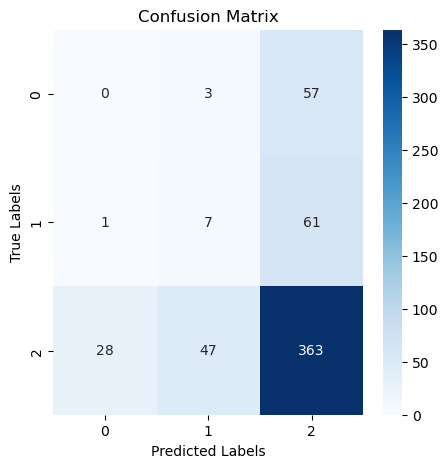

In [51]:
eval(test_x,test_y,bmodel)

**Observation:**
Model 2, with bias introduced, shows marginal improvement in overall accuracy compared to Model 1 but at a cost to the predictive capabilities for minority classes (Class 0 and Class 1). The model's effectiveness is heavily skewed towards Class 2, demonstrating significant bias which compromises its utility across a balanced dataset. 

### Plot Loss

In [52]:
colors = ['blue', 'green']  # Define as many colors as you have lines to plot
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()


import matplotlib.pyplot as plt

def plot_metrics(history, title, colors):
  metrics = ['loss', 'prc', 'precision', 'recall']
  plt.figure(figsize=(12, 10))  # Define a larger figure size to avoid overlapping subplots

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    plt.title(title + ' - ' + name)

# Usage example:
careful_bias_colors = ['blue', 'green']  # Define a pair of colors for careful_bias_history
zero_bias_colors = ['red', 'purple']  # Define a pair of colors for zero_bias_history

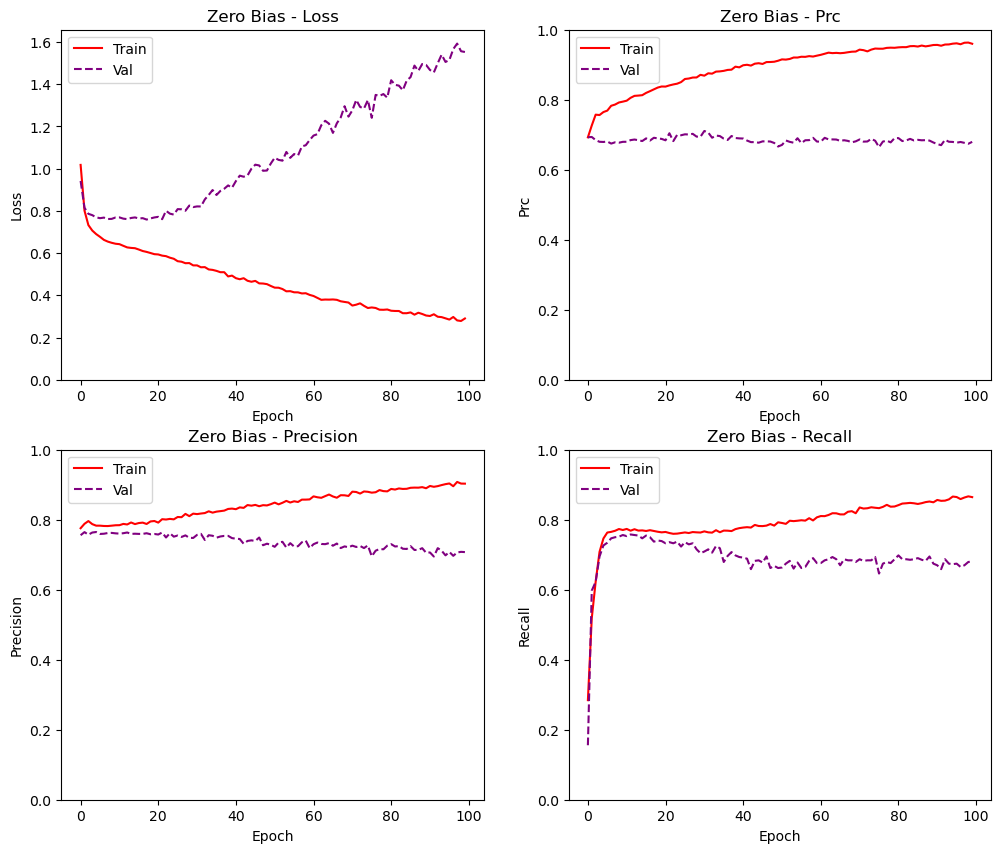

In [53]:
plot_metrics(zero_bias_history, 'Zero Bias', zero_bias_colors)

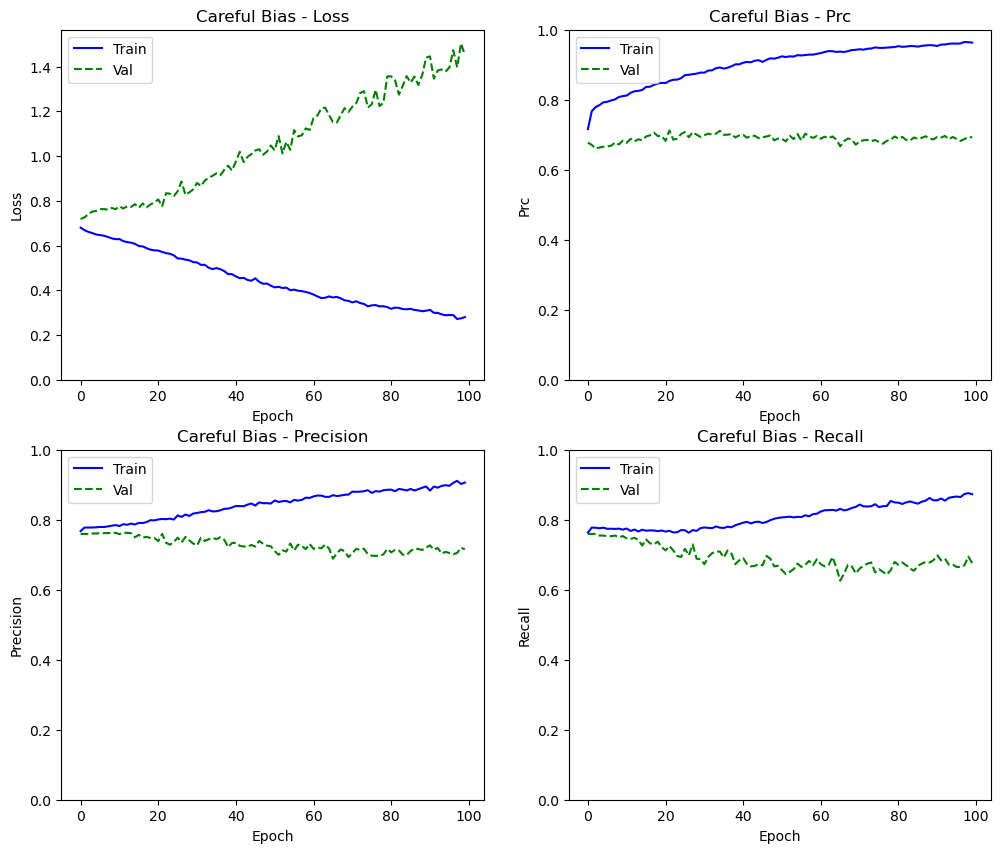

In [54]:
plot_metrics(careful_bias_history, 'Careful Bias', careful_bias_colors)

### 3. Model with Class Weights and NO bias

In [55]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights_path)
# Reset the biases of the last layer to zero
dense_layer = weighted_model.layers[-1].layer  # Access the Dense layer wrapped by TimeDistributed
zero_bias = np.zeros(dense_layer.units)  # Create a zero array with the same length as the number of units in the Dense layer
dense_layer.bias.assign(zero_bias)       # Assign the zero array to the bias of the Dense layer
weighted_history = weighted_model.fit(
    train_x,
    train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.15,
    class_weight=class_weights)

Epoch 1/100
19/19 [==============================] - 5s 68ms/step - loss: 1.0760 - categorical cross entropy: 1.1501 - Brier score: 0.2136 - tp: 432.0000 - fp: 182.0000 - tn: 8266.0000 - fn: 3792.0000 - categorical_accuracy: 0.3393 - precision: 0.7036 - recall: 0.1023 - auc: 0.5934 - prc: 0.4260 - val_loss: 1.1042 - val_categorical cross entropy: 1.1042 - val_Brier score: 0.2246 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1272.0000 - val_fn: 636.0000 - val_categorical_accuracy: 0.1997 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4961 - val_prc: 0.2999
Epoch 2/100
19/19 [==============================] - 0s 12ms/step - loss: 1.0555 - categorical cross entropy: 1.0662 - Brier score: 0.2154 - tp: 54.0000 - fp: 32.0000 - tn: 7144.0000 - fn: 3534.0000 - categorical_accuracy: 0.3966 - precision: 0.6279 - recall: 0.0151 - auc: 0.6054 - prc: 0.4217 - val_loss: 1.0878 - val_categorical cross entropy: 1.0878 - val_Brier score: 0.2204 - val_tp: 0.0000e+00 - val_fp: 0.

6/6 [==============================] - 1s 4ms/step
Shape of pred: (189, 3)
Shape of test_y: (189, 3)
Accuracy: 0.5502645502645502
              precision    recall  f1-score   support

           0       0.10      0.15      0.12        60
           1       0.14      0.19      0.16        69
           2       0.76      0.66      0.71       438

    accuracy                           0.55       567
   macro avg       0.33      0.33      0.33       567
weighted avg       0.61      0.55      0.58       567

Confusion Matrix:
 [[  9   5  46]
 [  9  13  47]
 [ 71  77 290]]


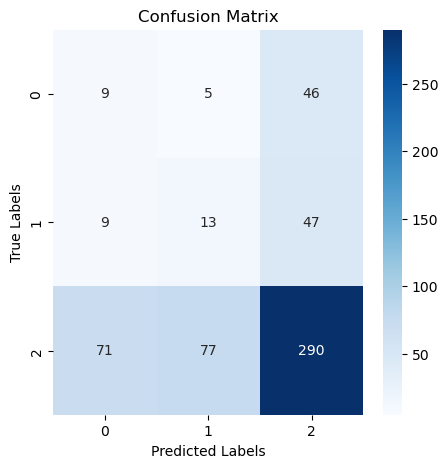

In [56]:
eval(test_x,test_y,weighted_model)

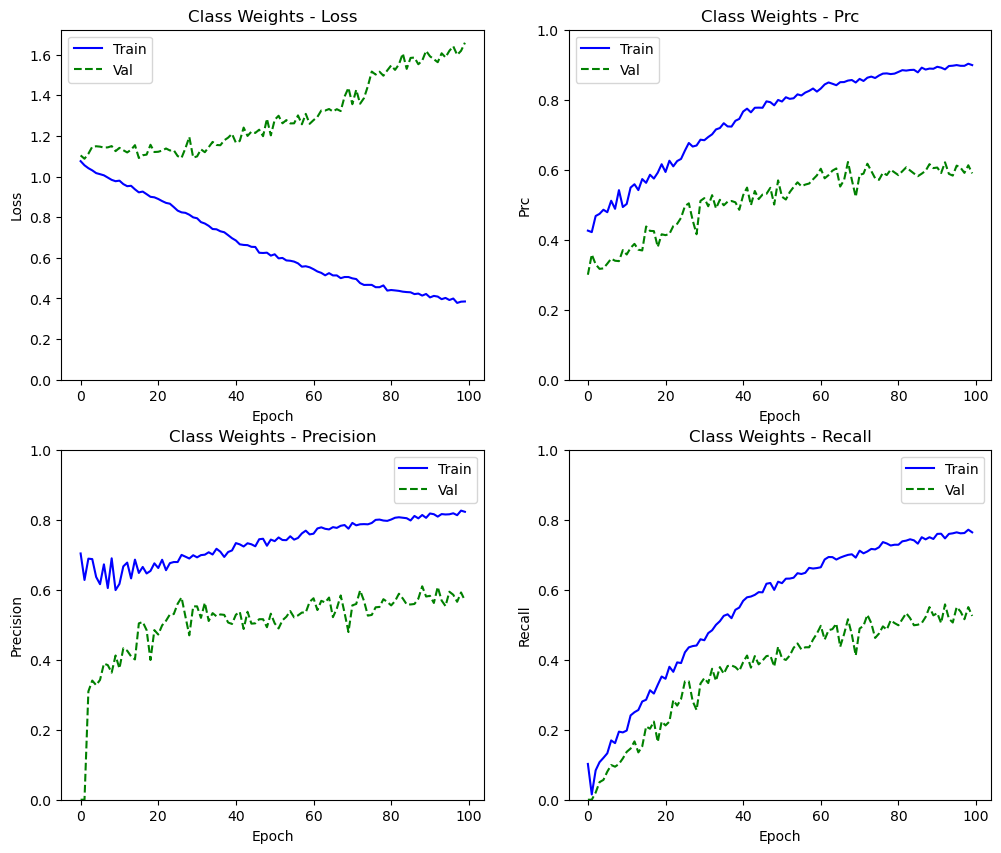

In [57]:
plot_metrics(weighted_history,"Class Weights",colors)

**Observation:**
Model 3 demonstrates an approach where class weights are adjusted to improve the detection of minority classes (Class 0 and Class 1), resulting in better balanced performance metrics across all classes. However, this adjustment leads to a reduction in accuracy, particularly for the majority class (Class 2). This model, while not as accurate overall, offers a more equitable approach to class representation. 

### 4. Model with Class weights and Bias 

In [58]:
wbiasmodel = make_model()
wbiasmodel.load_weights(initial_weights_path)
Wbias_history = wbiasmodel.fit(
    train_x,
    train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.15,
    class_weight=class_weights)

Epoch 1/100
19/19 [==============================] - 5s 67ms/step - loss: 1.4217 - categorical cross entropy: 0.8339 - Brier score: 0.1400 - tp: 3122.0000 - fp: 1047.0000 - tn: 7401.0000 - fn: 1102.0000 - categorical_accuracy: 0.7429 - precision: 0.7489 - recall: 0.7391 - auc: 0.8224 - prc: 0.6815 - val_loss: 0.7338 - val_categorical cross entropy: 0.7338 - val_Brier score: 0.1354 - val_tp: 482.0000 - val_fp: 153.0000 - val_tn: 1119.0000 - val_fn: 154.0000 - val_categorical_accuracy: 0.7594 - val_precision: 0.7591 - val_recall: 0.7579 - val_auc: 0.8284 - val_prc: 0.6770
Epoch 2/100
19/19 [==============================] - 0s 11ms/step - loss: 1.2030 - categorical cross entropy: 0.8154 - Brier score: 0.1538 - tp: 2080.0000 - fp: 681.0000 - tn: 6495.0000 - fn: 1508.0000 - categorical_accuracy: 0.6873 - precision: 0.7534 - recall: 0.5797 - auc: 0.8174 - prc: 0.7190 - val_loss: 1.0487 - val_categorical cross entropy: 1.0487 - val_Brier score: 0.2063 - val_tp: 217.0000 - val_fp: 160.0000 - 

6/6 [==============================] - 1s 4ms/step
Shape of pred: (189, 3)
Shape of test_y: (189, 3)
Accuracy: 0.48677248677248675
              precision    recall  f1-score   support

           0       0.07      0.13      0.10        60
           1       0.10      0.14      0.12        69
           2       0.72      0.59      0.65       438

    accuracy                           0.49       567
   macro avg       0.30      0.29      0.29       567
weighted avg       0.58      0.49      0.53       567

Confusion Matrix:
 [[  8   6  46]
 [  5  10  54]
 [ 94  86 258]]


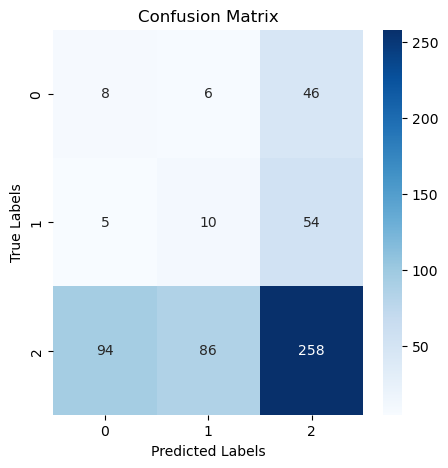

In [59]:
eval(test_x,test_y,wbiasmodel)

**Observation:** 
Model 4 highlights the challenges of balancing accuracy with class representation in the presence of inherent biases and class weights. While there is a slightly more balanced approach to recognizing minority classes, the overall accuracy suffers significantly.It still struggles to provide a robust solution to class imbalance.

## 5. CategoricalFocalLoss - To handle Class Imbalance for Neural Networks

In [60]:
# Define the Categorical Focal Crossentropy loss function
class CategoricalFocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(CategoricalFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)
        pt = tf.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss

In [61]:
# Define the LSTM model with TimeDistributed Dense layer
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    Reshape((train_y.shape[1], -1)),
    TimeDistributed(Dense(train_y.shape[2],))
])


alpha = [1, 10, 10]  # Adjust the values according to the imbalance

# Compile the model with Categorical Focal Crossentropy loss function and custom alpha and gamma values
model.compile(optimizer='adam', loss=CategoricalFocalLoss(alpha=alpha, gamma=2.0), metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 9, 50)             12600     
                                                                 
 dropout_12 (Dropout)        (None, 9, 50)             0         
                                                                 
 lstm_13 (LSTM)              (None, 9, 50)             20200     
                                                                 
 dropout_13 (Dropout)        (None, 9, 50)             0         
                                                                 
 reshape_6 (Reshape)         (None, 3, 150)            0         
                                                                 
 time_distributed_6 (TimeDi  (None, 3, 3)              453       
 stributed)                                                      
                                                      

In [62]:
# Define some callbacks to improve training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, min_delta=0.005)

# Calculate the number of steps per epoch
steps_per_epoch = len(train_x) // BATCH_SIZE

# Fit the model with specified steps per epoch
model.fit(train_x, train_y, epochs=EPOCHS, batch_size=BATCH_SIZE, steps_per_epoch=steps_per_epoch, validation_split=0.15, verbose=1, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
22/22 [==============================] - 4s 39ms/step - loss: 2.5998 - accuracy: 0.6892 - val_loss: 2.3736 - val_accuracy: 0.7594 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 0s 8ms/step - loss: 2.0779 - accuracy: 0.7726 - val_loss: 2.2858 - val_accuracy: 0.7594 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 0s 7ms/step - loss: 2.0376 - accuracy: 0.7707 - val_loss: 2.3008 - val_accuracy: 0.7594 - lr: 0.0010
Epoch 4/100
22/22 [==============================] - 0s 7ms/step - loss: 1.8978 - accuracy: 0.7834 - val_loss: 2.3034 - val_accuracy: 0.7594 - lr: 0.0010
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: 1.9064 - accuracy: 0.7783 - val_loss: 2.3061 - val_accuracy: 0.7594 - lr: 0.0010
Epoch 6/100
22/22 [==============================] - 0s 6ms/step - loss: 1.9168 - accuracy: 0.7752 - val_loss: 2.3500 - val_accuracy: 0.7594 - lr: 0.0010
Epoch 7/100
22/22 [==============================] - 0s 6ms/step - loss: 1.

6/6 [==============================] - 1s 3ms/step
Shape of pred: (189, 3)
Shape of test_y: (189, 3)
Accuracy: 0.7689594356261023
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.00      0.00      0.00        69
           2       0.77      1.00      0.87       438

    accuracy                           0.77       567
   macro avg       0.26      0.33      0.29       567
weighted avg       0.60      0.77      0.67       567

Confusion Matrix:
 [[  0   0  60]
 [  0   0  69]
 [  2   0 436]]


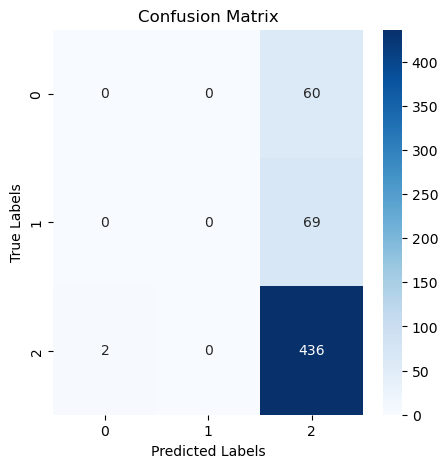

In [63]:
eval(test_x, test_y, model)

**Observation:**
This Model employs categorical focal loss in an effort to focus training on more challenging cases, particularly underrepresented classes. Despite this intent, it does not manage to improve predictions for Classes 0 and 1 and instead reinforces high accuracy solely for Class 2, mirroring the difficulties seen in Models 2 and 4.

# Conclusion

The comparative analysis of the five models highlights the trade-offs between overall accuracy and class-specific performance in addressing class imbalance. Models 1 and 2, focusing on minimal bias and introduced bias respectively, showed moderate to slightly improved accuracies but failed significantly in recognizing minority classes. Model 3, employing class weights, and Model 4, combining bias and class weights, aimed to balance class representation but at a cost to overall accuracy and without resolving the misclassification issues effectively. Model 5, using Categorical Focal Loss, achieved the highest accuracy but completely neglected minority classes, predicting nearly all cases as the majority class. 